In [1]:
import pandas as pd
import script_reglas

import nltk as nltk
from emoji import UNICODE_EMOJI
import unicodedata as unicodedata
import re
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

[NbConvertApp] Converting notebook script_reglas.ipynb to script
[NbConvertApp] Writing 4295 bytes to script_reglas.py


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
respuestas=pd.read_excel('s3://presidencia-mi-salud/processed/results_export_964.xlsx', encoding='utf-8')

In [3]:
respuestas=respuestas[['Contact UUID', 'URN', 'Name', 'Groups', 'Response 9 (Text) - uncaught']]
respuestas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'texto']

In [4]:
categoria_reglas=pd.DataFrame()
for i in range(0, respuestas.shape[0]):
    respuesta_regla=pd.DataFrame(script_reglas.procesa_reglas(str(respuestas['texto'].iloc[i])), index=[i])
    categoria_reglas=pd.concat([categoria_reglas, respuesta_regla])
respuestas=pd.concat([respuestas[['id_contacto', 'urn', 'nombre_contacto', 'listas']],
                      categoria_reglas], axis=1)

In [ ]:
print(respuestas.shape)
respuestas=respuestas.loc[respuestas.texto!='nan']
print(respuestas.shape)

In [6]:
respuestas.result.value_counts()

modelo           974
like-fb          480
si               309
gracias          184
hola             136
no               114
informacion       96
ok                95
emoji             36
spam              23
twitter-image     13
hasta luego        6
pregunta           4
aborto             2
Name: result, dtype: int64

In [7]:
etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')

In [8]:
respuestas_etiquetas=pd.merge(respuestas, etiquetado[['id_contacto', 'categ_opi', 'Clasificacion final']],how='left',
                              on=['id_contacto'])
print(respuestas_etiquetas.shape)

(2472, 11)


In [9]:
respuestas_etiquetas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result',
       'texto', 'texto_proc', 'wc', 'categ_opi', 'categ_final']

In [10]:
respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']

In [11]:
respuestas_etiquetas.categ_final.loc[respuestas_etiquetas.categ_final.isnull()]=respuestas_etiquetas.categ_opi.loc[respuestas_etiquetas.categ_final.isnull()]

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True).to_csv('compara_etiquetas.csv')

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta,All
categ_final,,,,,,,,,
cancelar,0,0,1,0,0,0,0,4,5
emergencia,5,1,0,0,1,0,0,0,7
informacion,0,42,0,4,0,0,0,2,48
nacimiento,0,0,7,0,0,0,0,0,7
otra,0,0,0,267,1,0,0,3,271
otra_queja,0,0,0,0,140,3,1,1,145
otra_registro,0,0,0,0,0,0,0,7,7
pregunta,0,21,0,2,1,309,3,1,337
pregunta_busca trabajo,0,0,0,1,0,0,57,0,58


In [12]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='cancelar')]='respuesta'
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='otra_registro')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.texto=='¿Cómo saben que estoy triste?')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta,All
categ_final,,,,,,,,,
emergencia,5,0,0,0,1,0,0,0,6
informacion,0,42,0,4,0,0,0,2,48
nacimiento,0,0,7,0,0,0,0,0,7
otra,0,1,0,267,1,0,0,10,279
otra_queja,0,0,0,0,140,3,1,1,145
pregunta,0,21,0,2,1,309,3,1,337
pregunta_busca trabajo,0,0,0,1,0,0,57,0,58
pregunta_medica,4,3,0,1,0,9,0,1,18
respuesta,0,2,6,0,0,1,0,67,76


In [15]:
map_fac=pd.factorize(respuestas_etiquetas.categ_final)[1]
respuestas_etiquetas.categ_final=pd.factorize(respuestas_etiquetas.categ_final)[0]
respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final

In [16]:
label_map={0:'otra',
          1:'informacion',
          2: 'nacimiento',
          3: 'respuesta',
          4: 'emergencia',
          5: 'pregunta',
          6: 'pregunta_busca trabajo',
          7: 'otra',
          8: 'pregunta'}

In [17]:
respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final.map(label_map)

## preprocesamiento

In [18]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()

 ### Quitar leading y trailing spaces, quitar puntuacion

In [19]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

In [20]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['texto_proc'].str.count('\\?')>0

In [21]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.replace('[^\w\s]','')

In [22]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

### Capturar emojis

In [23]:
es_emoji=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    es=pd.DataFrame({'es':script_reglas.is_emoji(respuestas_etiquetas['texto'].iloc[i])}, index=[0])
    es_emoji=pd.concat([es_emoji, es], ignore_index=True)
print(es_emoji.shape[0]==respuestas_etiquetas.shape[0])

True


In [24]:
respuestas_etiquetas=respuestas_etiquetas.reset_index(drop=True)

In [25]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, es_emoji], axis=1)

### Quitar emojis que quedan en el texto

In [26]:
sinemojis=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinemojis_i=script_reglas.give_emoji_free_text(respuestas_etiquetas.texto_proc.iloc[i])
    sinemojis_i=pd.DataFrame({'texto':sinemojis_i}, index=[i])
    sinemojis=pd.concat([sinemojis, sinemojis_i])
respuestas_etiquetas['texto_proc']=sinemojis

### Quitar  acentos

In [27]:
sinacentos=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinacentos_i=unicodedata.normalize('NFD', respuestas_etiquetas['texto_proc'].iloc[i]).encode('ascii', 'ignore').decode('utf-8')
    sinacentos_i=pd.DataFrame({'texto':sinacentos_i}, index=[i])
    sinacentos=pd.concat([sinacentos, sinacentos_i])
respuestas_etiquetas['texto_proc']=sinacentos

In [28]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('ola|\n|buena noche|buenos dias|buenos dia|buen dia|buenas noches|buenas tardes|buenas tarde|buen dia|bien dia|buena tardes|buena tarde|saludos|hola', '')

### Procesar dummy de  listas

In [29]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

In [30]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

prueba_listas=respuestas_etiquetas.listas.str.split(expand=True)
lista=[pd.get_dummies(prueba_listas[col]) for col in prueba_listas]

for i in range(0, len(lista)):
    lista[i]['indice'] = lista[i].index
lista=pd.concat(lista, ignore_index=True)
prueba_listas=lista.groupby('indice', as_index=True).agg('sum')

Eliminar listas con pocas personas

In [31]:
prueba_listas=prueba_listas[prueba_listas.sum()[~(prueba_listas.sum()<=3)].keys()]

### TF-DF

In [32]:
stop=nltk.corpus.stopwords.words("spanish")

In [33]:
for i in range(0, np.shape(stop)[0]):
    stop[i]=unicodedata.normalize('NFD', stop[i]).encode('ascii', 'ignore').decode('utf-8')

In [34]:
stemmer = SnowballStemmer("spanish")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [35]:
stemmed=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    stemmed_i=' '.join(tokenize_and_stem(respuestas_etiquetas.texto_proc[i]))
    stemmed_i=pd.DataFrame({'texto':stemmed_i}, index=[i])
    stemmed=pd.concat([stemmed, stemmed_i])
respuestas_etiquetas['texto_proc_stem']=stemmed

In [36]:
#respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.texto_proc.ravel()!='']

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 1]),
                        stop_words=stop)
features = tfidf.fit_transform(respuestas_etiquetas.texto_proc)
labels = respuestas_etiquetas.categ_opi
features.shape

(974, 361)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 2]),
                        stop_words=stop)
features_stem = tfidf.fit_transform(respuestas_etiquetas.texto_proc_stem)
labels = respuestas_etiquetas.categ_final
features_stem.shape

(974, 538)

In [39]:
x_target=respuestas_etiquetas.categ_opi
x_train=respuestas_etiquetas.texto_proc_stem

In [40]:
totalvocab_stemmed = []
totalvocab_tokenized = []
lista_fin=list()
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [41]:
from sklearn.feature_selection import chi2

N = 5
for category_id in sorted(respuestas_etiquetas.categ_final.unique()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# '0':
  . Most correlated unigrams:
. nacional
. llam
. oficin
. escuel
. extension
  . Most correlated bigrams:
. analisis confirm
. porqu antibiot
. bols trabaj
. asi com
. algun numer
  . Most correlated trigrams:
. 
# '1':
  . Most correlated unigrams:
. ofrec
. habl
. pais
. pagin
. embaraz
  . Most correlated bigrams:
. contr bacteri
. baj preci
. informacion porqu
. men lech
. campan vacunacion
  . Most correlated trigrams:
. 
# '2':
  . Most correlated unigrams:
. person
. dias
. may
. nadi
. atend
  . Most correlated bigrams:
. jug yogur
. contr bacteri
. ningun product
. disculp podri
. much graci
  . Most correlated trigrams:
. 
# '3':
  . Most correlated unigrams:
. porfavor
. inform
. doctor
. nadi
. enfermeri
  . Most correlated bigrams:
. ningun product
. disculp podri
. much graci
. deb pas
. com pued
  . Most correlated trigrams:
. 
# '4':
  . Most correlated unigrams:
. per
. atend
. motiv
. dolor
. gratuit
  . Most correlated bigrams:
. acud par
. compr ningun
. ant

### Pruebas número de factores

In [42]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
#import umap
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(context='notebook', style='white', rc={'figure.figsize':(20,20)})


In [43]:
labs=x_target.factorize()[1]
x_target=x_target.factorize()[0]

In [44]:
def loo(i, a):
    features_i=features[i].toarray()
    features_menos_i=np.delete(features.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    Xall=pd.DataFrame(features_menos_i)
    clasificador=RandomForestClassifier()
    loo_predict_proba=pd.DataFrame()
    X_i=pd.DataFrame(features_i)
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier()
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                      pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                     ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [45]:
from datetime import datetime

In [46]:
precision=pd.DataFrame()

for a in range(5, 100):
    inicio=datetime.now()
    loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, a) for i in respuestas_etiquetas.index)

    fin=datetime.now()

    loo_predict_proba=pd.concat(loo_predict_proba)

    loo_predict_proba.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result', 'texto',
                  'texto_proc', 'wc', 'categ_opi', 'categ_final', 'n_interrogacion', 'es',
    'pred_loo', 0, 1, 2, 3, 4, 5, 6, 7, 8]

    precision_i=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
    print(str(a)+ '\n')
    precision_i=pd.DataFrame({'precision':precision_i,
                  'tiempo_entrenamiento':(fin-inicio),'n_loadings':a}, index=[a])
    precision=pd.concat([precision, precision_i],)
    precision.to_csv('precision_loadings.csv')
    print(precision_i)

KeyboardInterrupt: 

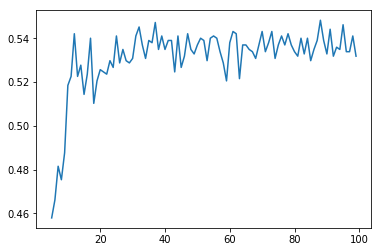

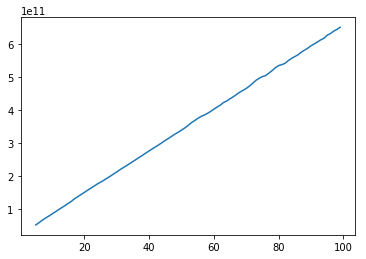

In [132]:
plt.plot(precision.n_loadings, precision.precision)
plt.show()
plt.plot(precision.n_loadings, precision.tiempo_entrenamiento)
plt.show()

In [146]:
pca=TruncatedSVD(n_components=33)
Xall=pca.fit_transform(features)
Xall=pd.DataFrame(Xall)

inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, 33) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

   # print(str(i)+ ' ' +
   #       loo_predict_proba_i[[0, 1, 2, 3, 4, 5, 6, 7, 8]].idxmax(axis=1).astype(str)[i]+ ' ' +
   #       loo_predict_proba_i.categ_final.astype(str)[i] + ' '+loo_predict_proba_i.texto.astype(str)[i])

0:03:52.995486


In [147]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [148]:
loo_predict_proba.columns

Index([    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es',                 0,                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8],
      dtype='object')

In [149]:
loo_predict_proba.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result', 'texto',
                  'texto_proc', 'wc', 'categ_opi', 'categ_final', 'n_interrogacion', 'es',
'pred_loo', 0, 1, 2, 3, 4, 5, 6, 7, 8]

(loo_predict_proba['pred_loo']==x_target).mean()


0.5451745379876797

In [152]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.3585891677650054


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [154]:
pd.crosstab(loo_predict_proba['pred_loo'], x_target)

col_0,0,1,2,3,4,5,6,7,8
pred_loo,,,,,,,,,
0,168,17,1,68,1,54,8,28,11
1,2,6,0,0,0,4,1,3,0
2,0,0,6,0,1,2,0,0,0
3,4,0,0,3,0,2,0,0,1
5,82,22,0,3,3,254,24,38,6
6,4,0,0,0,0,2,21,3,0
7,19,3,0,1,1,18,4,73,0
8,0,0,0,1,0,1,0,0,0


In [155]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['n_interrogacion'].astype(int)

In [252]:

prueba_ensamble=pd.concat([respuestas_etiquetas[['wc', 'es', 'n_interrogacion']],
                           Xall_test], ignore_index=False, axis=1)

### FEATURES DE FLUJOS

In [118]:
flujos=pd.read_csv('s3://presidencia-mi-salud/processed/flujos_peticiones.csv')

In [119]:
flujos.head()

,Unnamed: 0,contact_uuid,flujo_penultimo,flujo_ultimo,nombre,penultimo_tmstmp,texto,ultimo_tmstmp
0,0,3bf0c4bb-d5db-4e0d-ab29-98a7ee6b2b6a,b_consejo_w22_d3,b_development_w22_d4,NaN,2018-08-07T16:02:20.331086Z,NaN,2018-08-08T14:10:16.479863Z
1,1,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,NaN,2018-03-23T18:14:42.214452Z,La solicitud de enviar el SMS por Cobrar a 552...,2018-03-23T18:14:42.955021Z
2,2,7ea8e04b-e8d0-4628-bf35-350a784d5e2f,Fin_SMS,prueba_fb,pedro vallejo,2018-05-17T18:31:38.123141Z,🙅,2018-06-19T18:32:13.198465Z
3,3,3059e012-6fd3-445d-8da4-5fc36d45f8dc,b_concerns_w4_d4,cancelar_misalud,NaN,2018-03-02T15:01:46.787861Z,NaN,2018-03-02T16:25:41.512518Z
4,4,42bf4e3f-a396-4eb7-a987-b76cba779e92,b_nutrition_w78_d4,prueba_fb,Rosy,2018-06-18T14:00:10.181403Z,Hola gordo,2018-06-19T18:32:13.198465Z


In [120]:

flujos=flujos[['contact_uuid', 'flujo_penultimo', 'flujo_ultimo', 'ultimo_tmstmp','penultimo_tmstmp' ]]

In [121]:
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.replace('Z|T', ' ')
flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.replace('Z|T', ' ')

flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.strip()
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.strip()
from datetime import datetime
for i in range(0, flujos.shape[0]):
    if  (flujos.ultimo_tmstmp[i] is np.nan) == False:
        flujos.ultimo_tmstmp[i]=datetime.strptime(flujos.ultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.ultimo_tmstmp[i]=None
    if  (flujos.penultimo_tmstmp[i] is np.nan) == False:
        flujos.penultimo_tmstmp[i]=datetime.strptime(flujos.penultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.penultimo_tmstmp[i]=None

In [122]:
flujos['delta']=flujos.ultimo_tmstmp-flujos.penultimo_tmstmp


In [123]:
delta_horas=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    dias=flujos.delta[i].days
    dias=dias*24
    horas=dias+flujos.delta[i].seconds/3600
    horas=pd.DataFrame({'delta_horas':horas}, index=[i])
    delta_horas=pd.concat([delta_horas, horas])
    

In [124]:
flujos=pd.concat([flujos, delta_horas], axis=1)

In [125]:
horas_ultimos=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    hora_ultimo=int(flujos.ultimo_tmstmp[i].strftime('%H'))
    hora_ultimo=pd.DataFrame({'hora_ultimo':hora_ultimo}, index=[i])
    horas_ultimos=pd.concat([horas_ultimos, hora_ultimo])
flujos=pd.concat([flujos, horas_ultimos], axis=1)   

In [126]:
flujos=flujos[['contact_uuid', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']]
flujos.columns=['id_contacto', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']

In [127]:
respuestas_etiquetas=pd.merge(flujos, respuestas_etiquetas, how='inner',on='id_contacto' )

In [196]:
def loo_masvar(i, a, df_extra):
    df_extra_orig=df_extra
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=pd.DataFrame(features_menos_i)
    
    
    
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [197]:
respuestas_etiquetas=pd.concat([prueba_listas,
           respuestas_etiquetas], axis=1)

In [204]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:05:36.753971


In [205]:

loo_predict_proba=pd.concat(loo_predict_proba)

loo_predict_proba=loo_predict_proba[['flujo_penultimo','flujo_ultimo','delta_horas','hora_ultimo',
                                     'urn','nombre_contacto','listas','cc','result','texto','texto_proc','wc',
                                     'categ_opi','categ_final','n_interrogacion','es','texto_proc_stem',
                                     0,1,2,3,4,5,6,7,8]]

loo_predict_proba.columns=['flujo_penultimo','flujo_ultimo','delta_horas','hora_ultimo',
                                     'urn','nombre_contacto','listas','cc','result','texto','texto_proc','wc',
                                     'categ_opi','categ_final','n_interrogacion','es','texto_proc_stem','pred_loo',
                                     0,1,2,3,4,5,6,7,8]

In [207]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
print(precision)

0.5739219712525667


In [208]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.43700807621715876


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [105]:
loo_predict_proba['pred_loo']=loo_predict_proba['pred_loo'].map(label_map)

In [112]:
loo_predict_proba.to_csv('./datos/prueba_loo_58_acc.csv')

In [106]:
pd.crosstab(loo_predict_proba['categ_opi'],loo_predict_proba['pred_loo'] )

pred_loo,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
categ_opi,,,,,,,,
emergencia,0,1,3,1,1,0,0,0
informacion,7,0,14,0,25,0,0,2
nacimiento,0,6,1,0,0,0,0,0
otra,4,0,145,18,67,6,1,38
otra_queja,0,0,30,74,36,5,0,0
pregunta,4,0,49,11,263,8,1,1
pregunta_busca trabajo,1,0,10,3,27,17,0,0
pregunta_medica,0,0,3,1,13,1,0,0
respuesta,0,0,26,1,0,0,0,49


El modelo sólo está clasificando como "información" si dice algo de números de teléfono y son frases cortas

Los nacimientos sí los clasifica bien por la palabra "mi bebé". El único que no cachó fue uno que dijo "ya tiv ami bb"

In [108]:
loo_predict_proba[['flujo_penultimo', 'flujo_ultimo',
                   'delta_horas', 'hora_ultimo',
                   'texto', 'texto_proc', 'texto_proc_stem', 'wc',
                   'categ_opi',
                   'pred_loo']].loc[(loo_predict_proba['categ_opi']=='pregunta_busca trabajo') &
                                   (loo_predict_proba['categ_opi']!=loo_predict_proba['pred_loo'])]

,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,texto,texto_proc,texto_proc_stem,wc,categ_opi,pred_loo
44,uncaught,uncaught,1769.28,19,Hols como están pregunta si soy de las segunda...,hols como estan pregunta si soy de las segunda...,hols com estan pregunt si soy de las segund et...,105,pregunta_busca trabajo,otra_queja
53,NaN,uncaught,NaN,21,"Hace falta más empleos para los nutriólogos, c...",hace falta mas empleos para los nutriologos co...,hac falt mas emple par los nutriolog com se su...,49,pregunta_busca trabajo,pregunta
70,NaN,uncaught,NaN,19,Hola buenas tardes disculpe la molestia mi nom...,disculpe la molestia mi nombre es abraham sa...,disculp la molesti mi nombr es abraham salg ha...,101,pregunta_busca trabajo,otra
91,uncaught,miAlta_General,0,13,"Tuxtla Gutiérrez Chiapas, a 16 de Marzo del 20...",tuxtla gutierrez chiapas a 16 de marzo del 201...,tuxtl gutierrez chiap a de marz del asunt el q...,100,pregunta_busca trabajo,pregunta
93,NaN,uncaught,NaN,14,"hola, buenos dias, me pueden informar como pue...",me pueden informar como puedo obtener mi ser...,me pued inform com pued obten mi servici socia...,16,pregunta_busca trabajo,pregunta
107,uncaught,miAlta_General,0,17,Hola! Soy de cd juarez.soy Nutriologa y me.gus...,soy de cd juarezsoy nutriologa y megustaria a...,soy de cd juarezsoy nutriolog y megustari apli...,20,pregunta_busca trabajo,pregunta
110,NaN,uncaught,NaN,21,"Hola buen dia, disculpe aun no se abre la conv...",disculpe aun no se abre la convocatoria para...,disculp aun no se abre la convocatori par nuev...,13,pregunta_busca trabajo,pregunta
146,NaN,uncaught,NaN,20,Hola buenas tardes! Mi nombre es Elvis Solarte...,mi nombre es elvis srte 26anos soy medico in...,mi nombr es elvis srte 26an soy medic integral...,59,pregunta_busca trabajo,pregunta
152,uncaught,miAlta_General,0,0,O donde envío mi currículum,o donde envio mi curriculum,o dond envi mi curriculum,5,pregunta_busca trabajo,pregunta
158,uncaught,miAlta_General,0,17,estan ocupando vacantes para limpieza,estan ocupando vacantes para limpieza,estan ocup vacant par limpiez,5,pregunta_busca trabajo,otra


In [117]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'

/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= loo_predict_proba['categ_opi'], average='micro')
print(precision)

0.5770020533880903


In [119]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.6550308008213552


In [296]:
pd.crosstab(loo_predict_proba['pred_loo'].map(label_map), loo_predict_proba['categ_opi'])

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,,
emergencia,0,0,0,0,0,1,0,0,0
informacion,0,8,0,2,1,2,1,0,0
nacimiento,1,0,4,0,0,1,0,0,0
otra,0,17,1,138,29,44,7,9,24
otra_queja,2,1,0,22,72,25,5,1,1
pregunta,3,20,2,80,38,256,24,8,3
pregunta_busca trabajo,0,0,0,3,3,6,21,0,0
pregunta_medica,0,0,0,1,1,1,0,0,0
respuesta,0,2,0,33,1,1,0,0,48


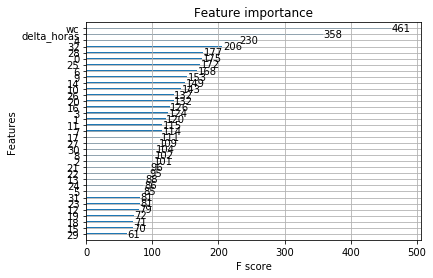

In [275]:
df_extra=respuestas_etiquetas[['delta_horas', 'wc']]

features_menos_i=features.toarray()
pca=TruncatedSVD(n_components=a)
pca=pca.fit(features_menos_i)
features_menos_i=pca.transform(features_menos_i)
Xall=pd.DataFrame(features_menos_i)
Xall=pd.concat([Xall,pd.DataFrame(df_extra.reset_index(drop=True))],axis=1)


clasificador=XGBClassifier()
clasificador=clasificador.fit(X=Xall,y=x_target)

from xgboost import plot_importance

plot_importance(clasificador)

In [157]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [158]:
pd.crosstab(loo_predict_proba['pred_loo_mod'],loo_predict_proba['categ_opi_mod'] )

categ_opi_mod,emergencia,informacion,nacimiento,otra,pregunta,pregunta_medica,respuesta
pred_loo_mod,,,,,,,
informacion,0,6,0,1,5,0,0
nacimiento,1,0,6,0,2,0,0
otra,1,19,0,291,78,7,65
pregunta,4,21,0,128,307,10,1
pregunta_medica,0,0,0,1,2,0,1
respuesta,0,2,1,3,1,1,9


In [160]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.635523613963039


### Doc2Vec

In [43]:
import gensim
from gensim.corpora import Dictionary

In [44]:
tokens=[]
for i in range(0, respuestas_etiquetas.shape[0]):
    tokens.append(tokenize_only(respuestas_etiquetas.texto_proc_stem[i]))


In [45]:
dictionary = Dictionary(tokens)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)


Dictionary(3368 unique tokens: ['a', 'cobr', 'de', 'el', 'envi']...)


In [46]:
#print(dictionary.token2id)

In [47]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

In [209]:
tokens=list()
for i in range(0, respuestas_etiquetas.shape[0]):
    tokens.append(TaggedDocument(tokenize_only(respuestas_etiquetas.texto_proc_stem[i]), [i]))

In [49]:
def doc2vecfeatures(a, tokens):
    tokens_i=tokens[0]
    tokens.pop(0)
    model = gensim.models.doc2vec.Doc2Vec(vector_size=a, min_count=2, epochs=40)
    model.build_vocab(tokens)
    model.train(tokens,
            total_examples=model.corpus_count,
            epochs=model.epochs)
    vec_i=pd.DataFrame(model.infer_vector(tokens_i[0])).transpose()
    vec_i.index=[i]
    tokens.append(tokens_i)
    vec_i=pd.concat([pd.DataFrame(respuestas_etiquetas[['id_contacto', 'texto', 'texto_proc','texto_proc_stem',
                      'wc', 'categ_opi', 'n_interrogacion', ]].loc[i]).transpose(), vec_i], axis=1)
    return(vec_i)

In [276]:
vec=pd.DataFrame()
for i in range(0, len(tokens)):
    print(i)
    vec_i=doc2vecfeatures(150,
                          tokens)
    vec=pd.concat([vec, vec_i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [277]:
vec.to_csv('./datos/doc2vec.csv')

In [212]:
from sklearn import manifold

In [213]:
tsne=manifold.TSNE()

In [232]:
vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.047069,0.081138,0.153531,0.291391,-0.152267,-0.213585,0.410336,-0.154152,-0.143451,0.076189,0.115509,0.299091,0.189024,0.031803,-0.050113,0.139061,0.162284,0.108374,0.071265,-0.144001,-0.350386,0.130664,0.071516,0.147849,0.013135,0.008751,0.127702,0.020766,0.150149,0.207352,-0.094315,0.025707,-0.372840,-0.069726,-0.014611,-0.146902,0.032884,0.154955,0.044600,0.118447,0.157564,-0.083927,-0.174046,-0.271082,0.034551,0.109118,0.241647,-0.104356,0.004637,-0.118482,-0.204105,-0.202478,0.075702,0.045551,-0.109057,-0.288899,-0.114930,-0.046662,0.072428,0.047097,0.066139,0.064119,0.080348,0.032129,0.072381,0.117085,-0.181884,-0.150817,-0.277865,0.208445,-0.042767,0.024123,0.092775,-0.051282,-0.049429,-0.203792,0.041483,-0.048401,0.068396,-0.199445,-0.116534,0.098603,0.019283,0.072451,-0.171825,0.071276,-0.163929,-0.139247,-0.089273,0.090775,0.040555,-0.009565,0.213378,-0.061950,-0.270810,0.204409,0.074361,-0.077727,0.104851,-0.170915
1,0.108803,0.137789,0.004451,0.094429,0.148543,-0.212582,0.237387,-0.169919,-0.059051,-0.109385,0.076377,0.005678,-0.065343,-0.002456,0.102936,0.064315,-0.095027,0.141714,-0.089922,-0.007010,-0.403562,-0.035354,-0.172887,0.027589,-0.083082,-0.023426,0.059065,-0.135262,0.258510,0.350186,0.063996,0.035611,-0.254378,-0.096234,-0.154232,0.068115,0.115443,0.133768,0.142512,0.301023,-0.005220,-0.168080,-0.159538,-0.163282,0.141108,0.229686,0.104291,-0.231040,-0.032271,-0.199048,-0.337585,-0.244972,0.152691,-0.013546,0.069860,0.130669,0.027907,-0.179670,0.176373,-0.037085,0.074463,-0.031897,0.032794,-0.086205,0.244621,0.185763,0.028792,0.039281,-0.410611,0.134018,0.014997,-0.044642,0.073920,0.017248,0.150019,-0.241630,-0.020512,0.004928,-0.026793,-0.014375,0.067218,-0.055278,-0.051273,-0.047484,-0.116093,0.254242,-0.180724,-0.183234,0.010394,-0.131850,0.050164,0.000736,0.059818,-0.101425,-0.165128,0.188340,0.087580,-0.102862,0.022218,0.094265
2,0.000488,0.002152,0.001028,0.000449,-0.000763,0.001459,-0.000624,0.003918,0.004637,-0.001166,0.002917,0.000289,0.000680,0.004256,-0.004290,-0.004129,-0.004798,0.003326,0.002782,0.003700,0.004786,0.002992,-0.000385,0.002805,-0.003817,0.001399,-0.003566,0.004447,0.000218,-0.000853,-0.002354,0.002742,-0.000438,0.000684,-0.004812,0.001176,0.001121,0.001169,0.004437,0.001818,-0.001405,-0.000630,0.001976,-0.004398,0.001668,0.001706,-0.002896,-0.003711,-0.001846,-0.001363,0.000702,-0.000614,0.004884,-0.003980,-0.002911,-0.003387,0.001531,-0.002467,-0.000337,-0.002556,-0.003410,-0.003896,0.001563,-0.003618,-0.003034,-0.001313,0.003210,-0.004029,0.003379,-0.004039,0.004765,-0.000313,0.004768,0.001048,0.002393,-0.004608,-0.002172,-0.003798,-0.002039,-0.003813,-0.001820,-0.000857,-0.004359,0.001925,0.000666,-0.002346,0.000232,-0.004061,0.000759,0.004293,-0.001814,0.001674,-0.003682,0.002163,-0.002106,-0.003168,0.000865,-0.004799,0.003289,-0.004953
3,0.041283,0.086206,-0.140835,-0.027046,0.036961,-0.144458,0.045581,0.012983,0.091056,0.006241,0.089645,0.053688,0.048379,0.010476,-0.064821,0.069075,-0.097156,-0.064189,-0.013894,-0.010346,-0.114236,-0.038558,-0.055925,0.126930,-0.056857,0.088843,0.106686,-0.049766,0.089528,0.180437,0.076648,0.030073,-0.072698,0.004459,-0.094835,0.035766,0.062692,0.025692,0.025707,0.064107,-0.018397,0.008392,0.050391,0.009149,-0.000963,0.055511,-0.130164,-0.113713,-0.047435,-0.125663,-0.088877,0.017872,-0.019852,0.158746,-0.036088,0.075432,0.084270,-0.124508,0.018090,0.060220,-0.029834,0.003323,-0.089824,0.024599,0.085421,0.056739,0.195047,-0.058574,-0.160656,-0.024021,-0.006750,0.026885,0.090183,0.037221,0.115675,-0.061092,0.040848,0.004772,0.146109,0.063088,0.024564,-0.050470,-0.013265,0.012747,-0.039703,0.014723,0.060473,-0.095932,-0.048993,-0.079730,-0.006290,-

In [233]:
tsne_fit=tsne.fit_transform(vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]])

In [234]:
tsne_fit=pd.concat([vec[['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem']],  pd.DataFrame(tsne_fit)], axis=1)

tsne_fit=pd.concat([respuestas_etiquetas['categ_opi'], pd.DataFrame(tsne_fit)], axis=1)

In [235]:
tsne_fit.head()

,categ_opi,id_contacto,texto,texto_proc,texto_proc_stem,0,1
indice,,,,,,,
0,otra,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,la solicitud de envi el sms por cobr a ha expi...,-9.364109,13.262014
1,otra,313822ff-7541-4db6-8fe1-a252363000ab,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,te llam y no pud localizart tramit en line tu ...,-11.537829,17.337954
2,informacion,86962a26-c021-4606-8986-893834ad83bd,59508,59508,,-26.511097,-2.401554
3,nacimiento,84b7624f-261d-44b4-83ba-6fade1a44c3a,Mi bebe,mi bebe,mi beb,-4.417261,-11.748837
4,respuesta,e083b2ea-6e2d-410c-b5a4-8067a818d485,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,si ya cad integr ten fot con la bb segu nos to...,5.294932,-3.083102


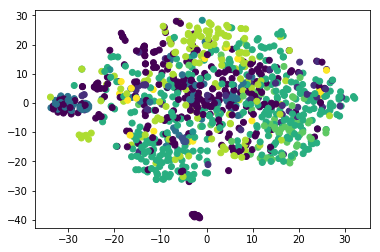

In [236]:
plt.scatter(tsne_fit[0],tsne_fit[1], c=tsne_fit.categ_opi.factorize()[0] )

In [278]:
def loo_masvar_2vec(i,df_extra):
    df_extra_orig=df_extra
    features_i=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].loc[i]
    
    features_i=pd.concat([pd.DataFrame(features_i).transpose(),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].drop(i, axis=0)
        
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i, axis=0))],axis=1)
    loo_predict_proba=pd.DataFrame()
        
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i, axis=0)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [280]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_2vec)(i, respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

KeyboardInterrupt: 

In [241]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [273]:
precision=f1_score(y_pred=loo_predict_proba.iloc[:, 68],y_true= x_target, average='micro')
print(precision)

0.5523613963039015


In [274]:
pd.crosstab(loo_predict_proba.iloc[:, 68], x_target)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
0,,,,,,,,,
informacion,0,1,0,2,0,4,0,0,0
nacimiento,1,0,2,1,0,0,0,0,0
otra,2,24,2,164,35,54,6,6,32
otra_queja,2,0,0,15,69,19,2,3,1
pregunta,1,20,0,68,40,246,33,9,4
pregunta_busca trabajo,0,0,0,2,1,12,17,0,0
respuesta,0,3,3,27,0,2,0,0,39
